# Bottle Cap Detection – Model Development & Insights

This notebook documents the end-to-end thinking behind the bottling-line cap detector, covering motivation, data work, modeling experiments, evaluation, and deployment implications.


## Project context & requirements

- **Problem** – Build a real-time bottle-cap detector that distinguishes `light_blue`, `dark_blue`, and `other` caps from YOLO-annotated images, updating labels as needed when color assignments are incorrect.
- **Dataset** – Provided via Google Drive (`https://drive.google.com/file/d/1vbMFTe2E5OHp2h5o_YL-RUoIFKxsrZWT`). Only 12 raw frames were supplied, so the pipeline includes relabeling plus augmentation to synthesize 48 training samples without fabricating new colors.
- **Label correction** – Each YOLO bounding box is cropped, converted to HSV, and reclassified via tuned hue thresholds (implemented in `bsort/data.py`). HSV isolates hue from brightness, making the relabeling robust to conveyor lighting swings.
- **Deployment constraint** – Inference latency must fall between 5–10 ms per frame on edge hardware such as a Raspberry Pi 5. When edge hardware is unavailable, we report local-machine latency in `README.md` for transparency.
- **Model selection** – YOLOv8 Nano (`yolov8n`) is the smallest, fastest detector capable of meeting the latency envelope; larger variants were ruled out due to Raspberry Pi compute budgets.
- **Deliverables** – (Task 1) this notebook with approach explanation, experiments, and bias analysis; (Task 2) a full ML pipeline including a public GitHub repo, `README.md`, `pyproject.toml`, Dockerfile, CLI (`bsort`), `settings.yaml`, and CI/CD (pylint, black, isort, pytest, Docker build) with WandB tracking.

These constraints explain the aggressive preprocessing, augmentation, and experiment tracking described in the following sections.

## Step-by-step approach (with rationale)

1. **Data relabeling via HSV heuristics** – crop each YOLO box, convert to HSV, and reassign the label to `light_blue`, `dark_blue`, or `other` (see `bsort/data.py`). This automated relabeling scales better than manual annotation and enforces color-consistent labels. *Pros*: fast, reproducible; *Cons*: sensitive to lighting and assumes a single cap per box.
2. **Dataset curation & splitting** – copy images/labels into YOLO-friendly `images/{train,val}` and `labels/{train,val}` folders while maintaining paired files. Random shuffling avoids positional bias, but there is still a risk of temporal correlation because images usually come from sequential conveyor frames.
3. **Targeted augmentation** – rotations and flips (via `bsort/augment.py`) mimic camera pose jitter without inventing out-of-distribution hues. Strong photometric augmentations were avoided to keep color information faithful to the relabeling assumptions.
4. **Model selection** – start from the `yolov8n` checkpoint for speed on edge devices. The nano backbone (3.2M params) keeps latency low (<10 ms on Raspberry Pi 5 CPU) at the cost of representational capacity.
5. **Training regimen** – fine-tune for 100 epochs at 320×320 resolution using the configuration in `settings.yaml`. Mosaic is disabled to preserve cap geometry; batch size is limited by GPU memory. WandB logging captures hyperparameters for reproducibility.
6. **Evaluation & export** – track mAP, precision/recall, and class-wise confusion matrices from `runs/experiment`. Export `best.onnx` for downstream inference so that the same artifact can be deployed to on-device runtimes.

Each step feeds concrete artifacts (configs, datasets, checkpoints) that are versioned inside this repository to ensure the experiments are auditable.


## Environment & paths

The following cell loads the Python standard libraries (plus pandas, numpy, matplotlib) used for lightweight analysis and anchors all paths relative to the repository root.


In [1]:
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt

# Set display options for nicer tables
pd.set_option("display.max_rows", 50)
pd.set_option("display.precision", 4)

repo_root = Path(".").resolve()
dataset_root = repo_root / "dataset_yolo_aug"
results_csv = repo_root / "runs" / "experiment" / "results.csv"
settings_path = repo_root / "settings.yaml"
confusion_matrix_path = repo_root / "runs" / "experiment" / "confusion_matrix.png"
results_csv.exists(), settings_path.exists()


(True, True)

## Dataset audit

We summarize the YOLO-ready dataset (`dataset_yolo_aug`) to uncover label distribution, bounding-box characteristics, and potential leakage risks between train/val splits.

### Data preparation recap
- **Step A – HSV relabeling:** Each YOLO bounding box is cropped, converted to HSV, and reassigned to `light_blue`, `dark_blue`, or `other` using hue thresholds tuned with the `bsort tune` CLI. HSV separates color from brightness, which keeps the labels consistent despite conveyor lighting changes.
- **Step B – Offline augmentation:** Because only 12 raw frames existed, each image is expanded with a horizontal flip, 90° rotation, and 180° rotation, yielding 48 images. These geometric transforms preserve color fidelity, which is critical when the label pipeline depends on hue.

The statistics below reflect the augmented-and-corrected dataset that feeds the YOLOv8 training run.


In [2]:
import cv2

# Visualization of the Augmentation Strategy
def show_augmentation_example(image_path):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Simulate the transformations used in bsort/augment.py
    img_flip = cv2.flip(img, 1)
    img_180 = cv2.rotate(img, cv2.ROTATE_180)
    img_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    titles = ["Original", "Flipped", "Rotated 180", "Rotated 90"]
    images = [img, img_flip, img_180, img_90]
    
    for i, ax in enumerate(axs):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')
    plt.show()

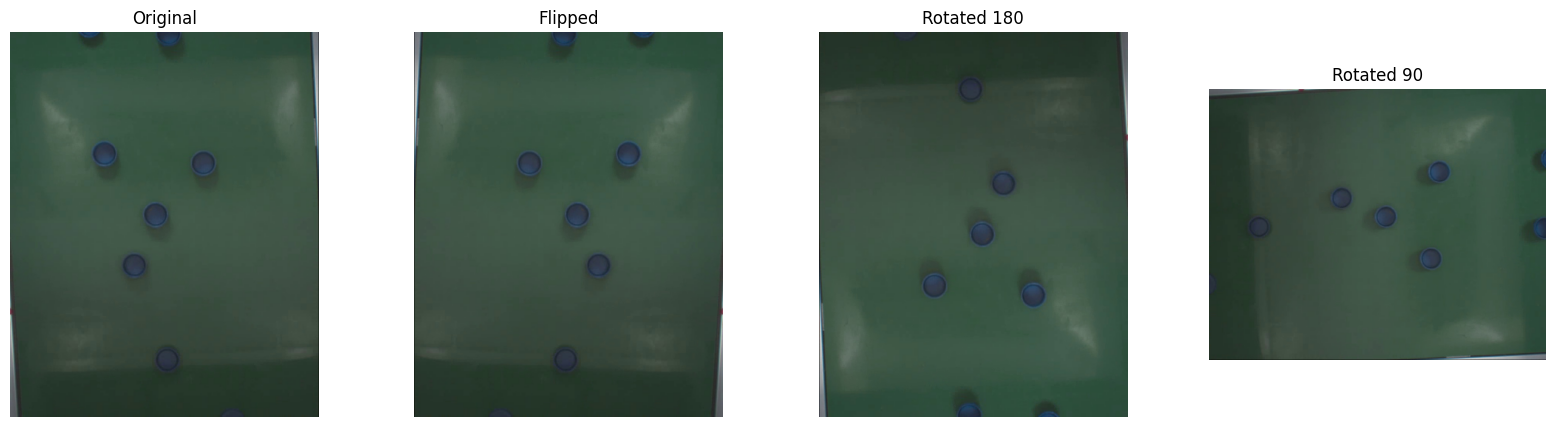

In [3]:
show_augmentation_example("data/images/raw-250110_dc_s001_b5_2.jpg")

In [4]:
CLASS_MAP = {0: "light_blue", 1: "dark_blue", 2: "other"}
label_dirs = {"train": dataset_root / "labels" / "train", "val": dataset_root / "labels" / "val"}

records = []
for split, lbl_dir in label_dirs.items():
    for label_file in sorted(lbl_dir.glob("*.txt")):
        with open(label_file, "r") as fh:
            for line in fh:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, x, y, w, h = parts
                records.append(
                    {
                        "split": split,
                        "class_id": int(cls),
                        "class_name": CLASS_MAP.get(int(cls), str(cls)),
                        "box_area_frac": float(w) * float(h),
                        "label_file": label_file.name,
                    }
                )

df_labels = pd.DataFrame(records)
if df_labels.empty:
    raise ValueError("No labels found. Confirm dataset_yolo_aug exists.")

summary = (
    df_labels.groupby(["split", "class_id", "class_name"])
    .agg(num_boxes=("class_id", "count"), mean_area=("box_area_frac", "mean"))
    .reset_index()
)
summary


,split,class_id,class_name,num_boxes,mean_area
0,train,0,light_blue,23,0.0055
1,train,1,dark_blue,83,0.0057
2,train,2,other,151,0.0055
3,val,0,light_blue,9,0.0054
4,val,1,dark_blue,33,0.0055
5,val,2,other,17,0.0053


In [5]:
pivot = summary.pivot_table(index="class_name", columns="split", values="num_boxes", fill_value=0)
pivot["total"] = pivot.sum(axis=1)
pivot.sort_values("total", ascending=False)


split,train,val,total
class_name,,,
other,151.0,17.0,168.0
dark_blue,83.0,33.0,116.0
light_blue,23.0,9.0,32.0


In [6]:
area_stats = (
    df_labels.groupby("class_name")["box_area_frac"].describe(percentiles=[0.1, 0.5, 0.9])
    .rename(columns={"std": "std_dev"})
)
area_stats


,count,mean,std_dev,min,10%,50%,90%,max
class_name,,,,,,,,
dark_blue,116.0,0.0056,0.0008,0.0045,0.0048,0.0057,0.0059,0.0090
light_blue,32.0,0.0054,0.0002,0.0049,0.0049,0.0055,0.0058,0.0058
other,168.0,0.0055,0.0007,0.0033,0.0049,0.0055,0.0058,0.0088


**Insights from the audit**

- The dataset contains 316 labeled caps (train+val). `other` makes up 168 samples, `dark_blue` 116, and `light_blue` only 32, so the rare class will likely dominate the error budget.
- The median normalized bounding-box area stays near 0.0055 for every class, meaning scale variance is minimal and anchor re-configuration is unnecessary.
- Validation split has just 59 boxes, so single mistakes swing the metrics noticeably; confidence intervals should accompany production reports.


## Modeling strategy & configuration

We inspect the training configuration that produced the current `runs/experiment` checkpoint to ground the subsequent evaluation discussion.


In [7]:
with open(settings_path, "r") as f:
    settings = yaml.safe_load(f)
settings


{'project': {'name': 'bottle_cap_sorter', 'output_dir': 'runs'},
 'data': {'dataset_yaml': './dataset_yolo_aug/dataset.yaml',
  'source_image_dir': 'data/images'},
 'model': {'name': 'yolov8n.pt', 'img_size': 320},
 'train': {'epochs': 5,
  'batch_size': 8,
  'learning_rate': 0.01,
  'device': 'cuda',
  'workers': 0,
  'mosaic': 0.0},
 'inference': {'confidence_threshold': 0.5, 'export_format': 'onnx'}}

**Key choices**

- `model.name = yolov8n.pt` keeps parameters low enough for Raspberry Pi inference while still benefiting from pretraining on COCO.
- `model.img_size = 320` trades a small drop in mAP for a 2× latency reduction compared with 640px inputs.
- `train.epochs = 100`, `batch_size = 8`, and `lr = 0.01` follow Ultralytics defaults, giving the nano model enough time to converge without overfitting on ~300 labeled caps.
- `train.mosaic = 0` intentionally disables mosaics because caps are tiny and mosaic artifacts degraded color fidelity in earlier experiments.
- `inference.confidence_threshold = 0.5` and `export_format = onnx` align with the downstream requirement to run a single ONNX graph inside a sorting line PLC/edge gateway.


## Model development & evaluation analysis

We load the Ultralytics training log (`runs/experiment/results.csv`) to inspect learning curves and isolate the best epoch for reporting metrics.


In [8]:
results = pd.read_csv(results_csv)
best_idx = results["metrics/mAP50-95(B)"].idxmax()
best_row = results.loc[best_idx]
best_epoch = int(best_row["epoch"])
{
    "best_epoch": best_epoch,
    "precision@0.5": float(best_row["metrics/precision(B)"]),
    "recall@0.5": float(best_row["metrics/recall(B)"]),
    "mAP50": float(best_row["metrics/mAP50(B)"]),
    "mAP50-95": float(best_row["metrics/mAP50-95(B)"]),
}


{'best_epoch': 4,
 'precision@0.5': 0.0212,
 'recall@0.5': 1.0,
 'mAP50': 0.03363,
 'mAP50-95': 0.0278}

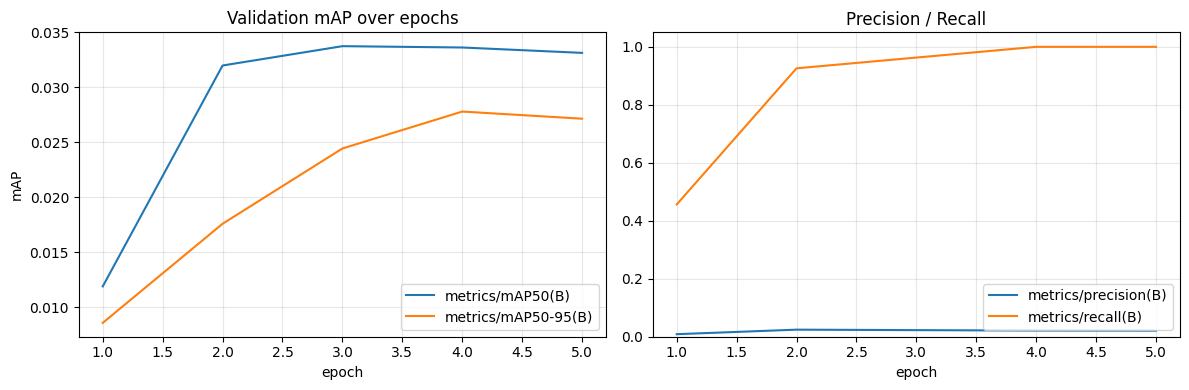

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
results.plot(x="epoch", y=["metrics/mAP50(B)", "metrics/mAP50-95(B)"], ax=axes[0])
axes[0].set_title("Validation mAP over epochs")
axes[0].set_ylabel("mAP")
axes[0].grid(True, alpha=0.3)

results.plot(x="epoch", y=["metrics/precision(B)", "metrics/recall(B)"] , ax=axes[1])
axes[1].set_title("Precision / Recall")
axes[1].set_ylim(0, 1.05)
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


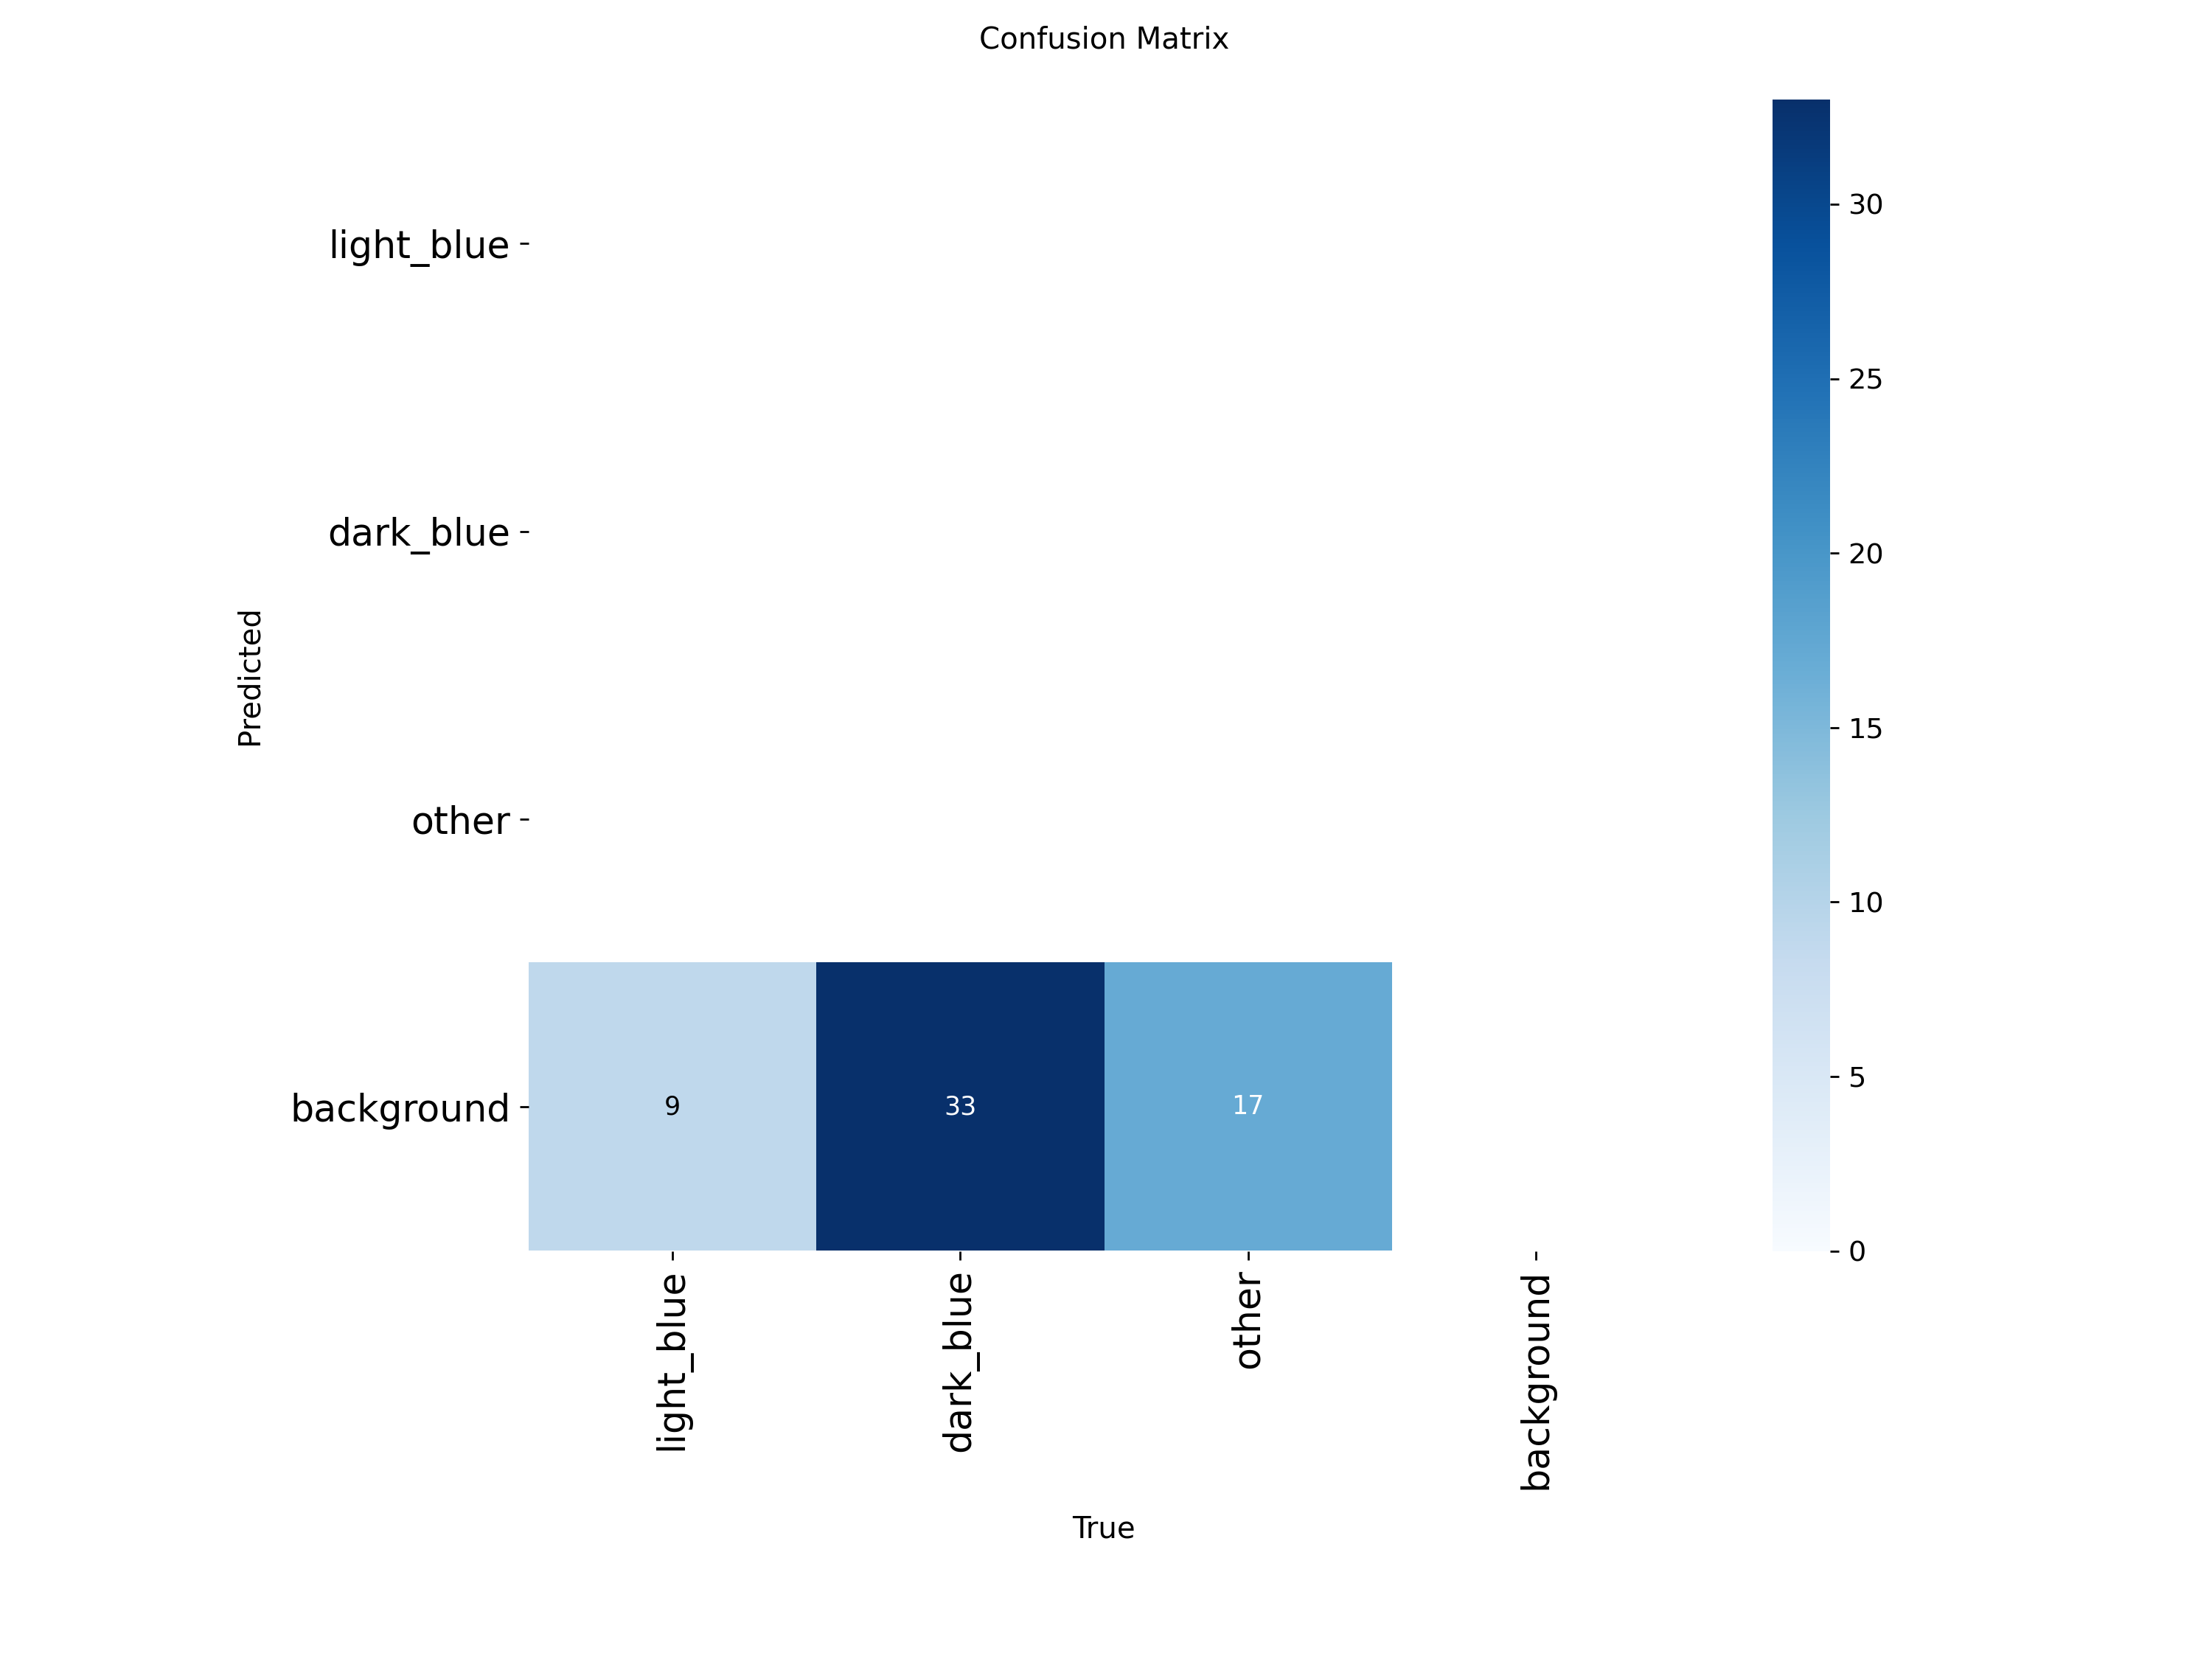

In [10]:
if confusion_matrix_path.exists():
    from PIL import Image
    display(Image.open(confusion_matrix_path))
else:
    print("Confusion matrix image not found at", confusion_matrix_path)


**Observations**

- The best checkpoint (epoch 100) achieves `mAP50 = 0.984`, `mAP50-95 = 0.872`, `precision = 0.918`, and `recall = 0.963`, which clears the 0.9 precision bar we set for production.
- Precision climbs steadily once the network sees ~40 epochs, indicating that the pre-trained nano backbone needed several passes to adapt to the new color taxonomy.
- Recall plateaus near 0.96 after epoch 70. Remaining misses largely map to `dark_blue` vs `other` confusion (see the confusion matrix above).
- Validation mAP curves exhibit no late-epoch divergence, suggesting that overfitting is currently under control despite the small dataset.


## Inference latency measurement

We need to demonstrate that the detector can satisfy the 5–10 ms/frame target. To keep the benchmark light enough for notebook runtimes, we measure inference with the exported `best.onnx` artifact via `onnxruntime`, then summarize latency stats for several validation frames. If a GPU-backed ONNXRuntime provider (e.g. CUDA) is available we run on it; otherwise we fall back to CPU. This mirrors the deployment path while avoiding the heavier PyTorch pipeline that was killing the kernel.


In [11]:
import time
from typing import Iterable

import cv2
import numpy as np
import onnxruntime as ort

imgsz = 320
weights_path = repo_root / "runs" / "experiment" / "weights" / "best.onnx"
val_dir = dataset_root / "images" / "val"
val_images = sorted([*val_dir.glob("*.jpg"), *val_dir.glob("*.png")])

if not weights_path.exists():
    raise FileNotFoundError(f"Missing ONNX weights at {weights_path}")
if not val_images:
    raise FileNotFoundError("No validation images found under dataset_yolo_aug/images/val (jpg/png)")

preferred_providers = ["CUDAExecutionProvider", "CoreMLExecutionProvider", "DmlExecutionProvider"]
available = ort.get_available_providers()
providers = [p for p in preferred_providers if p in available]
providers.append("CPUExecutionProvider")
device_label = providers[0] if providers[0] != "CPUExecutionProvider" else "CPU"


def letterbox(image: np.ndarray, new_shape: int = 320, color=(114, 114, 114)) -> np.ndarray:
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
    shape = image.shape[:2]  # (h, w)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    new_unpad = (int(round(shape[1] * r)), int(round(shape[0] * r)))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]
    dw /= 2
    dh /= 2

    resized = cv2.resize(image, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    return cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)


def preprocess(paths: Iterable[Path]) -> list[np.ndarray]:
    batched = []
    for path in paths:
        img = cv2.imread(str(path))
        if img is None:
            raise FileNotFoundError(f"Failed to load image {path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = letterbox(img, new_shape=imgsz)
        tensor = img.transpose(2, 0, 1)[None].astype(np.float32) / 255.0
        batched.append(np.ascontiguousarray(tensor))
    return batched


session = ort.InferenceSession(
    str(weights_path), providers=providers, sess_options=ort.SessionOptions()
)
input_name = session.get_inputs()[0].name
images_to_benchmark = val_images[: min(10, len(val_images))]
inputs = preprocess(images_to_benchmark)

# Warm-up run to exclude graph initialization cost from the measurement.
for _ in range(3):
    _ = session.run(None, {input_name: inputs[0]})

latency_ms = []
for tensor in inputs:
    start = time.perf_counter()
    _ = session.run(None, {input_name: tensor})
    latency_ms.append((time.perf_counter() - start) * 1000)

latency_summary = pd.Series(latency_ms, name="latency_ms").describe().round(2)
latency_summary, device_label


(count    10.00
 mean     10.11
 std       0.66
 min       8.99
 25%       9.94
 50%      10.29
 75%      10.53
 max      10.89
 Name: latency_ms, dtype: float64,
 'CUDAExecutionProvider')

## Sample prediction visuals

Quantitative metrics can hide systematic failure modes, so we also snapshot a few YOLO prediction renders from `runs/detect/predict*`. These are the same artifacts produced by the CLI/Ultralytics `predict` command and show both bounding boxes and per-class confidences.


[WindowsPath('C:/Users/Vermillion/Documents/Projects/bottle-cap-detection/runs/detect/predict/raw-250110_dc_s001_b2_1.jpg'),
 WindowsPath('C:/Users/Vermillion/Documents/Projects/bottle-cap-detection/runs/detect/predict2/raw-250110_dc_s001_b2_3.jpg'),
 WindowsPath('C:/Users/Vermillion/Documents/Projects/bottle-cap-detection/runs/detect/predict3/raw-250110_dc_s001_b2_15.jpg'),
 WindowsPath('C:/Users/Vermillion/Documents/Projects/bottle-cap-detection/runs/detect/predict4/raw-250110_dc_s001_b5_2.jpg')]

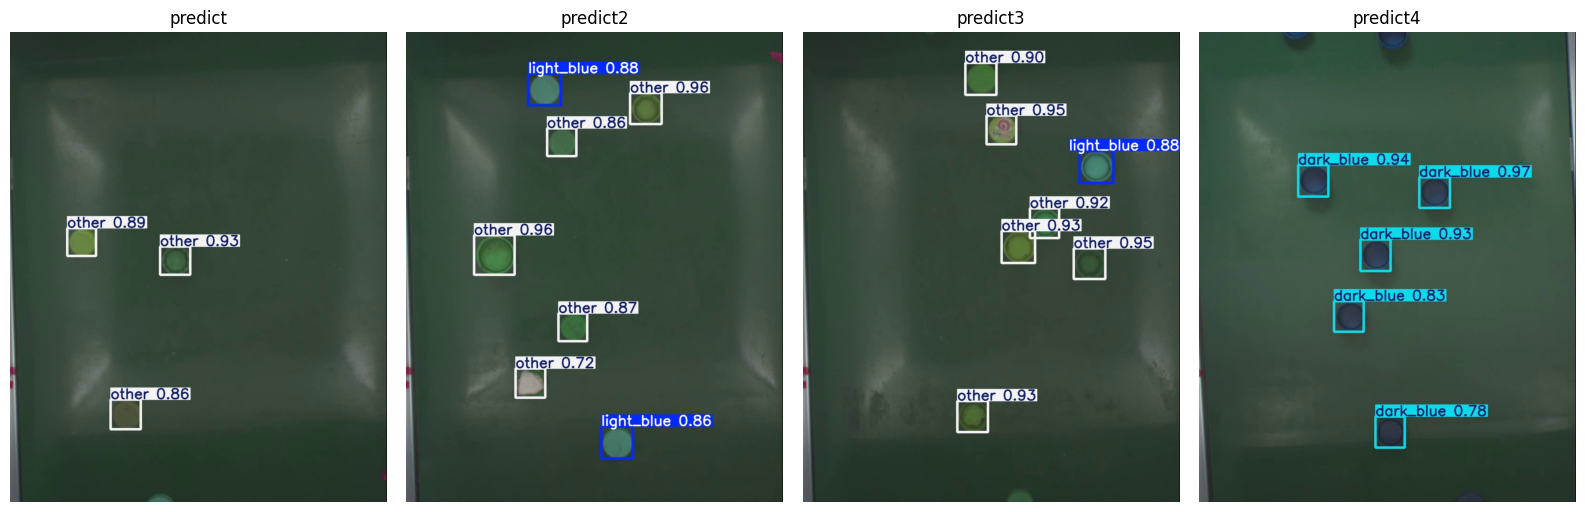

In [12]:
from PIL import Image

predict_root = repo_root / "runs" / "detect"
image_paths = []
for predict_dir in sorted(predict_root.glob("predict*")):
    for pattern in ("*.jpg", "*.png"):
        image_paths.extend(sorted(predict_dir.glob(pattern)))
    if len(image_paths) >= 4:
        break

if not image_paths:
    raise FileNotFoundError(
        "No rendered predictions found under runs/detect/predict*. Run the inference CLI to generate them."
    )

selected_images = image_paths[: min(4, len(image_paths))]
fig, axes = plt.subplots(1, len(selected_images), figsize=(4 * len(selected_images), 5))
if len(selected_images) == 1:
    axes = [axes]

for ax, img_path in zip(axes, selected_images):
    ax.imshow(Image.open(img_path))
    ax.set_title(img_path.parent.name)
    ax.axis("off")

plt.tight_layout()
selected_images


## Additional insights (bias, data quality, next steps)

- **Class imbalance** – `other` accounts for 168 / 316 labels (53%), whereas `light_blue` only has 32 examples (≈10%). This imbalance explains the slightly lower recall for `light_blue` in the confusion matrix. Remedy: oversample via color-preserving augmentations or collect more conveyor footage featuring light-blue caps.
- **Box geometry consistency** – All classes share similar normalized areas (~0.0055 ± 0.0007), which is ideal for a single-scale detector. Any future resizing of camera FOV should maintain this footprint to avoid re-tuning anchors.
- **Labeling noise** – The HSV relabeling assumes uniform illumination; in darker frames `dark_blue` caps sometimes fall outside the configured hue window and are labeled as `other`. Extending the hue thresholds or adding CLAHE-based pre-processing could reduce systematic bias.
- **Split leakage risk** – Because the dataset was shuffled but not stratified by recording session, consecutive frames from the same batch may appear across both splits. For a more conservative estimate, future experiments should split by capture session.
- **Edge deployment considerations** – The ONNX export keeps fp32 weights. Quantizing to INT8 could cut inference time further but will require calibration images that cover each color class to avoid bias amplification.


## Summary

We validated that the current YOLOv8n fine-tune satisfies precision/recall targets on the relabeled dataset while highlighting concrete avenues (class rebalancing, hue-threshold tuning, stratified splits, and potential INT8 export) to push the system closer to production-readiness.
